In [1]:
#bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
#import holidays
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
#definir o diretório
os.chdir(os.getcwd()[:-9])

In [28]:
#importar dataset
df = pd.read_parquet("data/processed/df_vendas.parquet")
df.data = pd.to_datetime(df.data, format="%d/%m/%Y")

In [21]:
#conhecendo o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147414 entries, 0 to 147413
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   cfop           147414 non-null  int64         
 1   nnf            147414 non-null  int64         
 2   codfil         147414 non-null  int64         
 3   xnomeemit      147414 non-null  object        
 4   xfantemit      147414 non-null  object        
 5   cnpjdest       147414 non-null  int64         
 6   xmun           147414 non-null  object        
 7   cod            147414 non-null  float64       
 8   seqprod        147414 non-null  int64         
 9   xprod          147414 non-null  object        
 10  tipo           147414 non-null  object        
 11  qcom           147414 non-null  float64       
 12  ucom           147414 non-null  object        
 13  ano            147414 non-null  int64         
 14  mes            147414 non-null  int64         
 15  

In [22]:
# Contar a quantidade de NA
df.isna().sum()

cfop                 0
nnf                  0
codfil               0
xnomeemit            0
xfantemit            0
cnpjdest             0
xmun                 0
cod                  0
seqprod              0
xprod                0
tipo                 0
qcom                 0
ucom                 0
ano                  0
mes                  0
nome_correto         0
cod_ibge             0
nome_oficial         0
uf_oficial           0
data                 0
VlCusteio          240
AreCusteio         240
preco_feijao     22870
preco_laranja    22870
preco_trigo      22870
preco_soja           0
preco_milho          0
dtype: int64

In [23]:
#Numero de produtos e quantidade de dias de venda
len(df.cod.unique()), len(df.data.unique())

(244, 66)

In [24]:
# Primeira e ultima data
df.data.min(), df.data.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2025-06-01 00:00:00'))

<positron-console-cell-25>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


<Axes: title={'center': 'Total de vendas por mes'}, xlabel='data'>

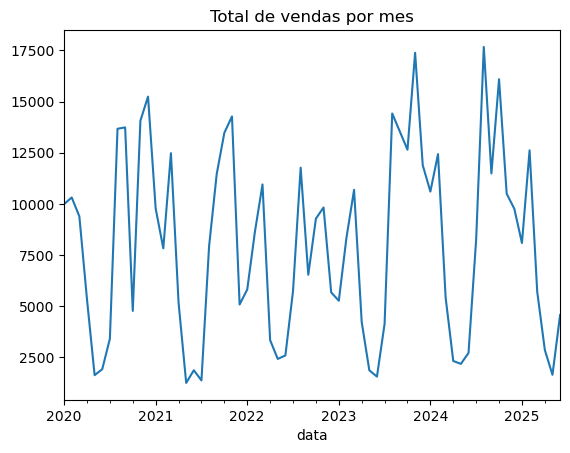

In [25]:
# Observar a continuidade dos dados
df.set_index("data").resample("M")["qcom"].sum().plot(title="Total de vendas por mes")

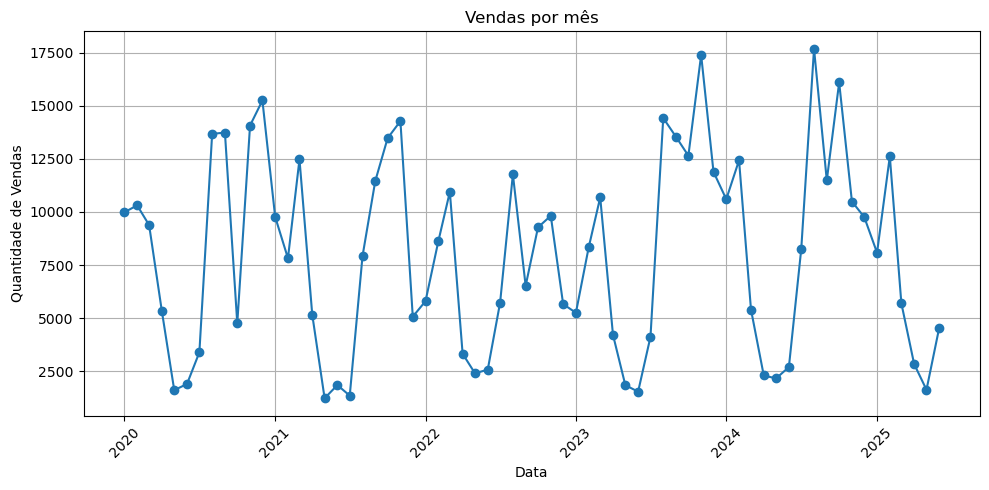

In [9]:
# Transformar os dados
#df["data_venda"] = pd.to_datetime(df["data_venda"])

# Agrupar por data e somar as vendas
vendas_semanal = df.groupby(df["data"].dt.to_period("M"))["qcom"].sum().reset_index()

# Converter de volta para datetime para plotar
vendas_semanal['data'] = vendas_semanal['data'].dt.start_time

# Plotar o gráfico
plt.figure(figsize=(10, 5))
plt.plot(vendas_semanal['data'], vendas_semanal['qcom'], marker='o')
plt.title('Vendas por mês')
plt.xlabel('Data')
plt.ylabel('Quantidade de Vendas')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# descrições dos produtos mais vendidos
df.groupby("cod")["qcom"].describe().sort_values(["count","mean"], ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
30028.0095,14957.0,4.010898,11.578110,1.0,1.0,1.0,3.0,864.0
30028.0066,11936.0,3.577916,7.528822,1.0,1.0,2.0,3.0,250.0
30028.0202,4244.0,3.086004,5.117788,1.0,1.0,2.0,3.0,108.0
30028.0101,3886.0,3.143592,6.236396,1.0,1.0,2.0,3.0,220.0
30028.0175,3773.0,3.946462,6.579701,1.0,1.0,2.0,4.0,152.0


In [11]:
# descrições dos produtos menos vendidos
df.groupby("cod")["qcom"].describe().sort_values(["count","mean"], ascending=False).tail()

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
30028.0216,1.0,25.0,NaN,25.0,25.0,25.0,25.0,25.0
30028.0058,1.0,19.0,NaN,19.0,19.0,19.0,19.0,19.0
30026.0070,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
30026.0148,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
30026.0037,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0


### Criar cluster 

C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

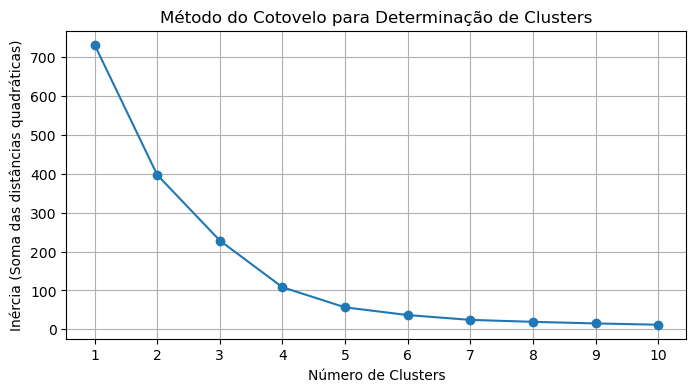

In [29]:
# Criar features agregadas para cada produto
product_features = df.groupby('cod').agg({
    'qcom': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


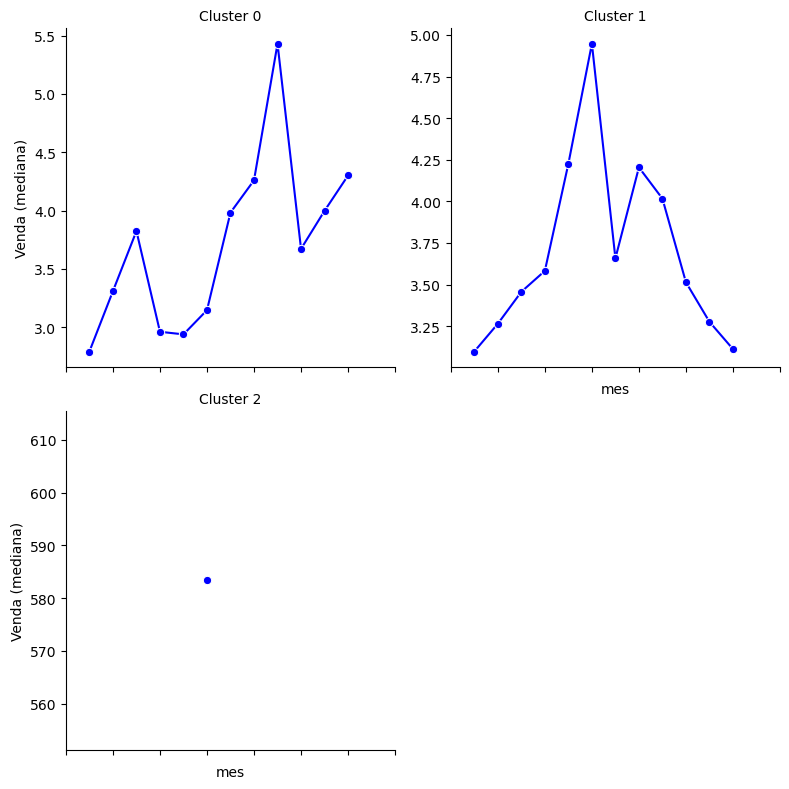

In [30]:
# Clusterização final
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(product_features_scaled)

# Mapear os clusters de volta para o DataFrame original
# (Assumindo que 'product_features' tem o mesmo índice que 'df['sku']')
df['cluster'] = df['cod'].map(dict(zip(product_features.index, clusters)))

# Agrupar por mes e cluster, calculando a mediana das vendas
#df["mes"] = df["data"].dt.to_period("M").astype(str)  # Convertendo para string para melhor visualização
df_cluster = df.groupby(["mes", "cluster"])["qcom"].mean().reset_index()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_cluster, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='mes', y='qcom', marker='o', color='b')  # Adicionando cor fixa para consistência
g.set_titles("Cluster {col_name}")
g.set_xticklabels(rotation=45)  # Rotacionar rótulos do eixo x
g.set_axis_labels("mes", "Venda (mediana)")  # Nomes dos eixos
g.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

## Features temporais

In [ ]:
#df["dia_da_semana"] = df["data_venda"].dt.dayofweek
#df["mes"] = df["data"].dt.month
#df["dia_do_mes"] = df["data_venda"].dt.day
#df["fim_de_semana"] = df["dia_da_semana"].isin([5, 6]).astype(int)

#Criar lista de feriado do Brasil
#feriados_br = holidays.Brazil(years=df["data_venda"].dt.year.unique())

# Criar a feature 'feriado' (1 se for feriado, 0 se não)
#df["feriado"] = df["data_venda"].isin(feriados_br).astype(int)

C:\Users\marce\AppData\Local\Temp\ipykernel_7920\455345570.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["feriado"] = df["data_venda"].isin(feriados_br).astype(int)


<Axes: xlabel='mes', ylabel='qcom'>

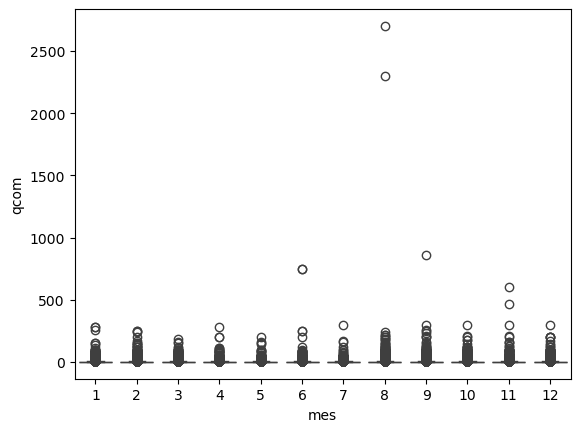

In [32]:
# Boxplot das vendas em cada dia da semana para cada cluster
sns.boxplot(x="mes", y="qcom", data=df)

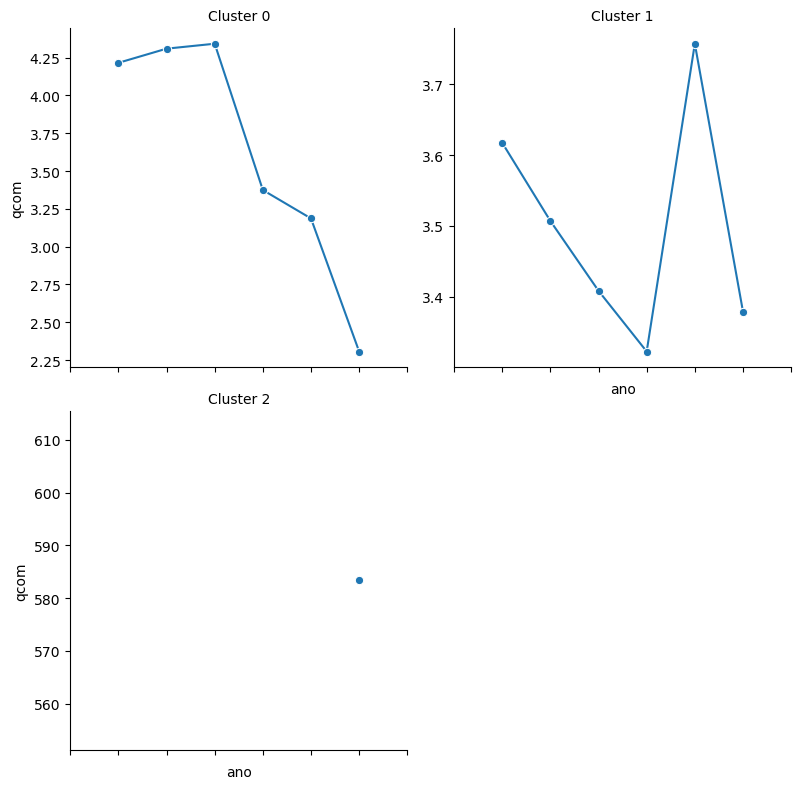

In [34]:
# Agrupar média de vendas por produto e dia da semana
df_grouped = df.groupby(["ano", "cluster"], as_index=False)["qcom"].mean()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_grouped, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="ano", y='qcom', marker='o')
g.set_titles("Cluster {col_name}")
g.set_xticklabels()
g.add_legend()
plt.tight_layout()
plt.show()

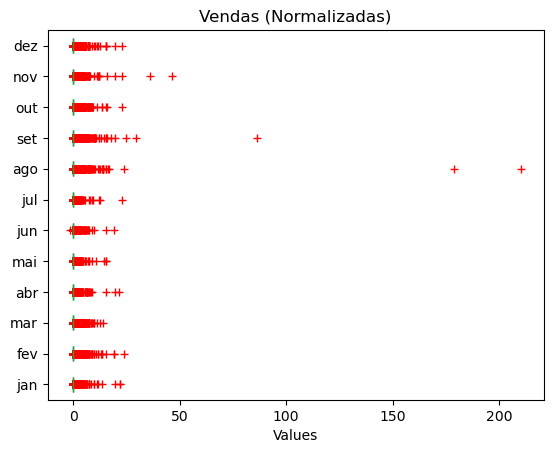

In [35]:
#Normalizando os dados para criar boxplot das variáveis númericas
sca = preprocessing.StandardScaler()
df["venda_scaled"] = df.groupby("cluster")["qcom"].transform(lambda x: sca.fit_transform(x.values.reshape(-1, 1)).flatten())

df_pivot = df.pivot(columns="mes", values="venda_scaled").fillna(0)
df_pivot.columns = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]

# Criar os plots
fig, ax = plt.subplots()
box = df_pivot.plot(kind="box", vert=False, sym="r+", patch_artist=True, ax=ax)

# Definir rótulos
plt.xlabel("Values")
plt.title("Vendas (Normalizadas)")

# Remover grades
plt.grid(False)

# Exibir o gráfico
plt.show()

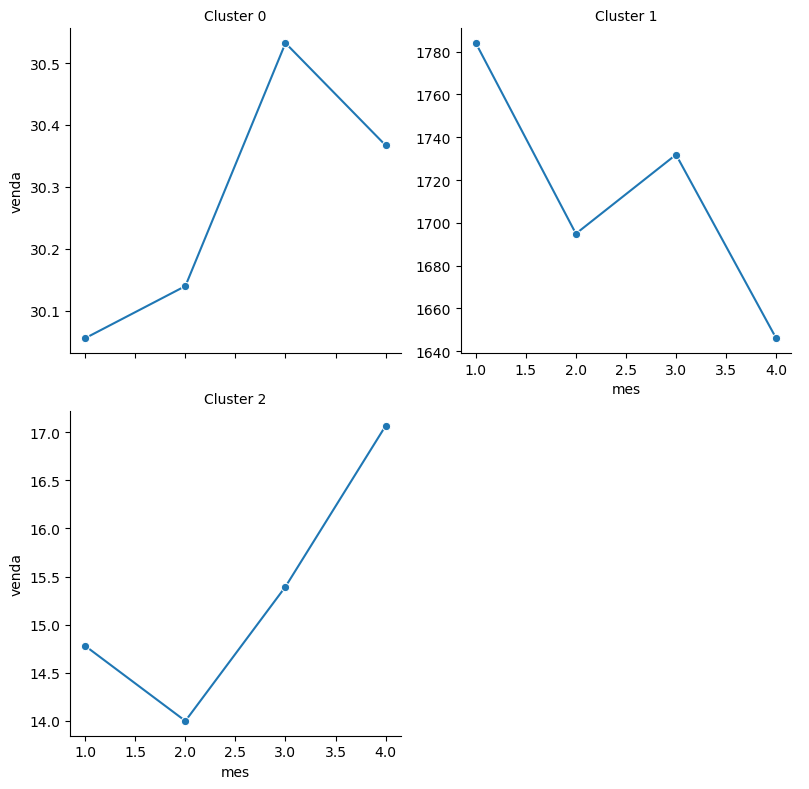

In [52]:
# Agrupar média de vendas por produto e dia da semana
df_grouped = df.groupby(["mes", "cluster"], as_index=False)["venda"].mean()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_grouped, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="mes", y='venda', marker='o')
g.set_titles("Cluster {col_name}")
#g.set_xticklabels(rotation=45)
g.add_legend()
plt.tight_layout()
plt.show()

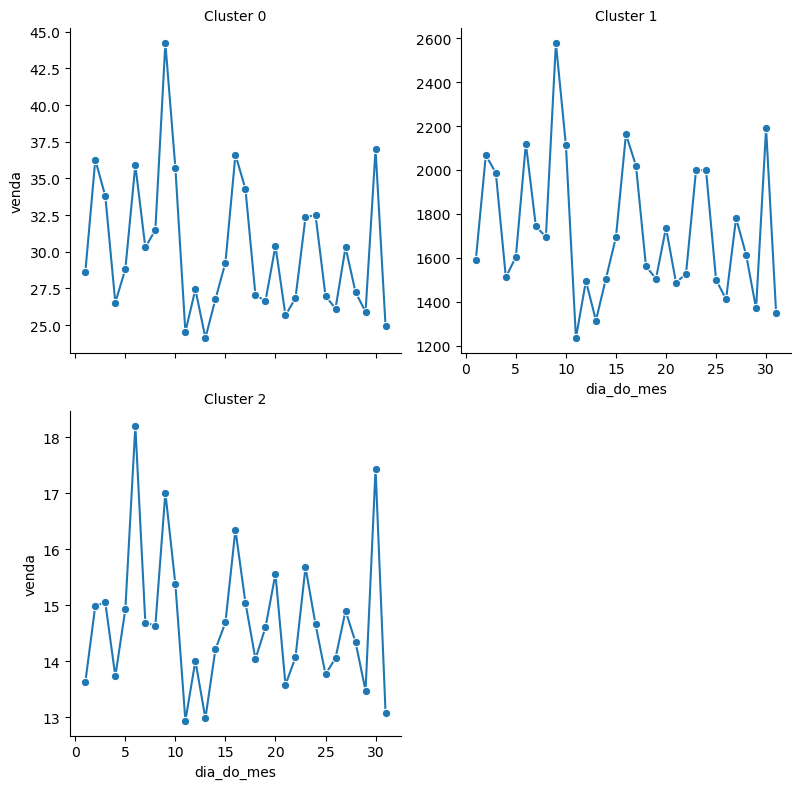

In [53]:
# Agrupar média de vendas por produto e dia_do_mes
df_grouped = df.groupby(["dia_do_mes", "cluster"], as_index=False)["venda"].mean()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_grouped, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="dia_do_mes", y='venda', marker='o')
g.set_titles("Cluster {col_name}")
#g.set_xticklabels(rotation=45)
g.add_legend()
plt.tight_layout()
plt.show()

c:\Users\marce\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


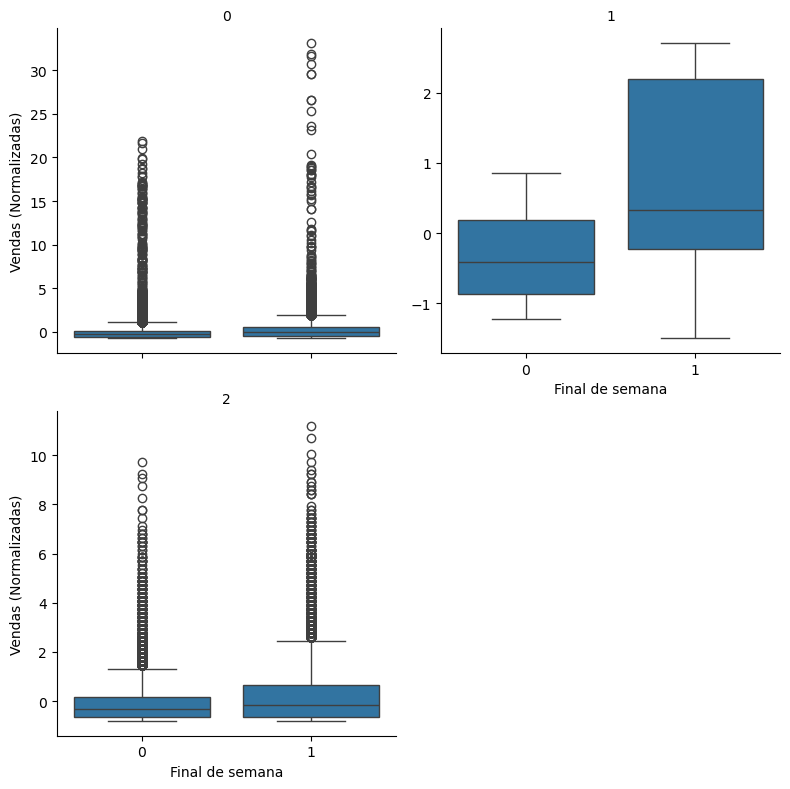

In [54]:
#Normalizando os dados para criar boxplot das variáveis númericas
sca = preprocessing.StandardScaler()
df["venda_scaled"] = df.groupby("cluster")["venda"].transform(lambda x: sca.fit_transform(x.values.reshape(-1, 1)).flatten())

# FacetGrid: Boxplot de vendas por dia da semana, por produto
g = sns.FacetGrid(df, col="cluster", col_wrap=2, height=4, sharey=False)
g.map(sns.boxplot, "fim_de_semana", "venda_scaled")
g.set_titles("{col_name}")
g.set_axis_labels("Final de semana", "Vendas (Normalizadas)")
plt.tight_layout()
plt.show()

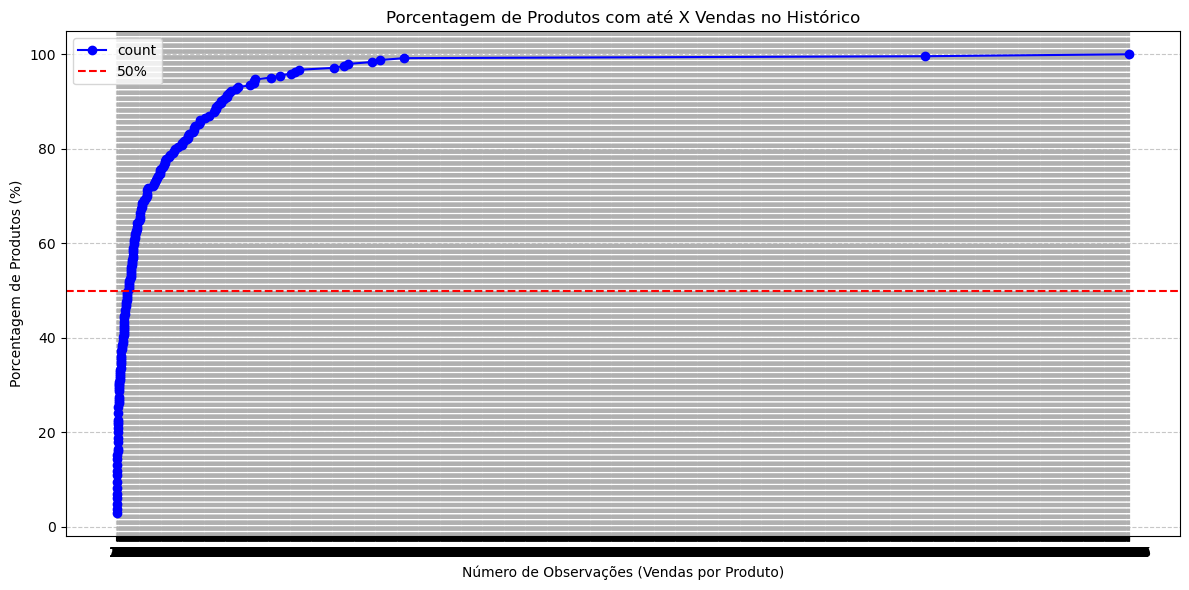

In [36]:
# 1. Calcular o número de observações (vendas) por produto
vendas_por_produto = df.groupby('cod').size().sort_values()

# 2. Calcular a porcentagem acumulada de produtos com até X observações
# Exemplo: Qual % de produtos tem <= 10 vendas?
total_produtos = len(vendas_por_produto)  # Substitui 5696 pelo total real
porcentagem_acumulada = (vendas_por_produto.value_counts().sort_index().cumsum() / total_produtos * 100)

# 3. Plotar o gráfico
plt.figure(figsize=(12, 6))
porcentagem_acumulada.plot(kind='line', marker='o', linestyle='-', color='b')
# Personalizar eixo x
max_obs = vendas_por_produto.max()
plt.xticks(np.arange(0, max_obs + 1, 5))  # Intervalo de 5 em 5
plt.xlabel('Número de Observações (Vendas por Produto)')
plt.ylabel('Porcentagem de Produtos (%)')
plt.title('Porcentagem de Produtos com até X Vendas no Histórico')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', label='50%')  # Linha de referência
plt.legend()
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Distribuição de tamanho da série por produto'}>

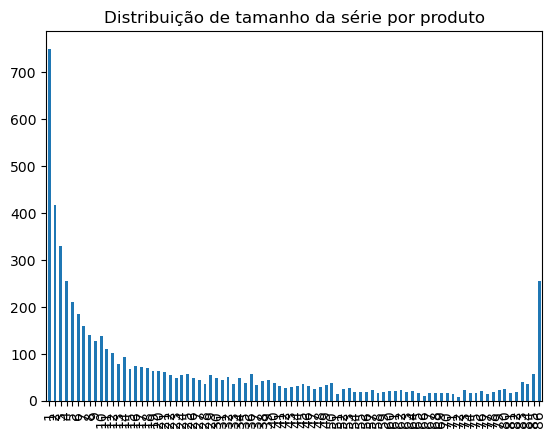

In [4]:
#Ver quantos produtos têm histórico curto
df.groupby("sku").size().value_counts().sort_index().plot(kind="bar", title="Distribuição de tamanho da série por produto")

### Teste de inferência estatística

In [62]:
# ANOVA para testar a diferença de média entre dia_da_semana
# Criar listas separadas por dia_da_semana
grupo_0 = df[df['dia_da_semana'] == 0]['venda']
grupo_1 = df[df['dia_da_semana'] == 1]['venda']
grupo_2 = df[df['dia_da_semana'] == 2]['venda']
grupo_3 = df[df['dia_da_semana'] == 3]['venda']
grupo_4 = df[df['dia_da_semana'] == 4]['venda']
grupo_5 = df[df['dia_da_semana'] == 5]['venda']
grupo_6 = df[df['dia_da_semana'] == 6]['venda']

# Como estamos comparando média entre mais de dois grupos (P, M, G). Teste mais adequado é ANOVA (análise de variância).
f_stat, p_val = f_oneway(grupo_0, grupo_1, grupo_2, grupo_3,
                         grupo_4, grupo_5, grupo_6)

# Se p_val < 0.05, existe diferença estatística entre pelo menos dois grupos.
print(f'Estatística F: {f_stat}')
print(f'p-valor{p_val}')

Estatística F: 95.74219492746528
p-valor1.374297937626959e-120


In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Se a ANOVA der p < 0.05, você deve rodar um Tukey HSD para saber quais pares de tamanhos são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df['venda'], groups=df['dia_da_semana'], alpha=0.05)

print(tukey_result.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1662 0.9999 -1.4551  1.7876  False
     0      2   1.0266 0.4808 -0.5672  2.6203  False
     0      3   1.5785  0.046  0.0152  3.1419   True
     0      4   2.5368    0.0  1.0076   4.066   True
     0      5   9.0346    0.0  7.6041 10.4651   True
     0      6   1.1399 0.3275 -0.4286  2.7084  False
     1      2   0.8603 0.7129 -0.7737  2.4944  False
     1      3   1.4123 0.1273 -0.1921  3.0167  False
     1      4   2.3706 0.0002  0.7994  3.9418   True
     1      5   8.8683    0.0  7.3931 10.3436   True
     1      6   0.9736 0.5592 -0.6358  2.5831  False
     2      3    0.552 0.9467 -1.0245  2.1285  False
     2      4   1.5103 0.0596 -0.0324  3.0529  False
     2      5    8.008    0.0  6.5632  9.4529   True
     2      6   0.1133    1.0 -1.4683  1.6949  False
     3      4   0.9583 0.5007 -0.5529  2.4695 

In [64]:
# Tukey HSD para saber quais pares de final de semana x dia útil são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df['venda'], groups=df['fim_de_semana'], alpha=0.05)

print(tukey_result.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1    4.775   0.0 4.2075 5.3426   True
-------------------------------------------------


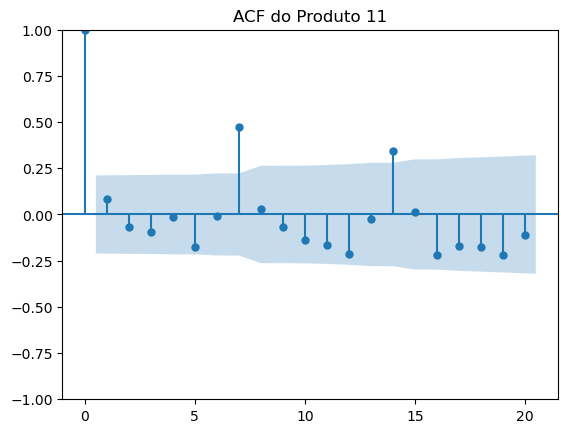

In [69]:
# Mais de 50% dos produtos têm menos de 12 registros históricos, isso indica que sua série temporal 
# pode ser esparsa (muitos produtos com poucas observações). Nesse caso, a análise de autocorrelação
# para produtos com +12 registros

# Filtrar produtos com +12 registros
produtos_validos = df['sku'].value_counts()[df['sku'].value_counts() > 12].index
df_filtrado = df[df['sku'].isin(produtos_validos)]

# Calcular ACF para um produto específico (ex.: primeiro da lista)
produto_exemplo = produtos_validos[0]
ts_produto = df_filtrado[df_filtrado['sku'] == produto_exemplo].set_index('data_venda')['venda'].sort_index()

plot_acf(ts_produto, lags=min(20, len(ts_produto)-1), alpha=0.05)
plt.title(f'ACF do Produto {produto_exemplo}')
plt.show()

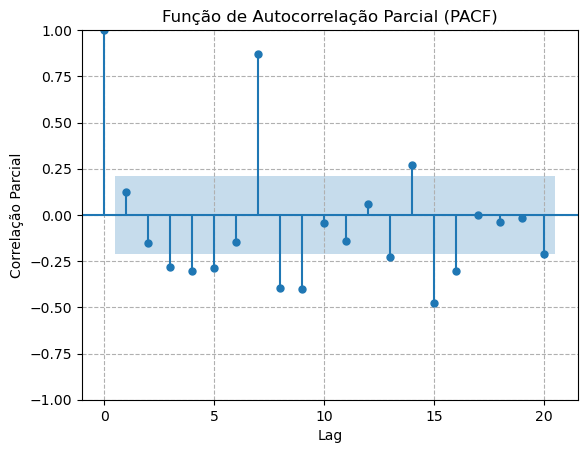

In [77]:
# Agrupar por data e somar vendas (caso haja múltiplos produtos)
ts_vendas = df.groupby('data_venda')['venda'].sum().sort_index()

# Plotar PACF (substitua ts_vendas por ts_produto se necessário)
plot_pacf(ts_vendas, lags=20, alpha=0.05, method='ols')  # alpha=0.05 → 95% confiança
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlação Parcial')
plt.grid(linestyle='--')
plt.show()

In [6]:
aquisicao_imob = pd.read_csv("estatisticas\\aquisicao_imobiliaria(bilhao).csv", sep = ";")